## Introduction

>
>
>
>
>

Hi, and welcome to our CIS 545 Project! 

Our group members are :
- Kelly Liang
- Henry Hung
- Kun Hwi Ko

Today, we are here to do the following :

* Step 1 : Navigate through a movies dataset, and clean for necessary data 
* Step 2 : Visualize the data to get initial insights 
* Step 3 : Reformat the data to be compatible for machine learning 
* Step 4 : Use K-Means Clustering to forecast what movies users will like  

## Packages / Setup

In [289]:
# data cleaning and visualization packages 
!pip install pandasql
import collections 
import numpy as np 
import pandas as pd
import pandasql as ps 
import re 
import matplotlib.pyplot as plt 
import seaborn as sns  

# machine learning packages 
import sklearn


In [ ]:
# Step 1 : install dependencies 
!pip install -q kaggle 

# Step 2 : create API Token from Kaggle and upload Kaggle.json 
# Instructions : https://www.kaggle.com/general/74235
from google.colab import files 
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kunhwiko","key":"ffde2dcdad62441bc64b6f73dbda3ec6"}'}

In [ ]:
# Step 3: additional steps 
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 4 : download the dataset 
# https://www.kaggle.com/rounakbanik/the-movies-dataset
!kaggle datasets download -d rounakbanik/the-movies-dataset

# Step 5 : Unzip the files 
!unzip the-movies-dataset.zip

 93% 212M/228M [00:02<00:00, 108MB/s] 
100% 228M/228M [00:02<00:00, 86.0MB/s]
Archive:  the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


## Data Cleansing

In [326]:
# retrieve Kaggle data 

ratings_df = pd.read_csv("/content/ratings.csv")
keywords_df = pd.read_csv("/content/keywords.csv")
movies_df = pd.read_csv("/content/movies_metadata.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Let's start by cleansing the keywords, movies, and rating dataframe.

In [327]:
# cleansing keywords

# Step 1 : get rid of rows without any keywords 
keywords_df = keywords_df[keywords_df['keywords'] != '[]']

# Step 2 : convert str --> [array of words]
def str_parser(strs):
  res = re.findall("name': '(.*?)'", strs)
  return res if res else None 

keywords_df['keywords'] = keywords_df['keywords'].apply(lambda x : str_parser(x))
keywords_df.dropna(inplace=True)

In [328]:
# cleansing movies

# Step 1 : drop unnecessary columns 
movies_df.drop(columns = ['adult', 'belongs_to_collection', 'budget', 'homepage', \
                          'imdb_id', 'original_language', 'original_title', 'overview', \
                          'poster_path', 'production_countries', 'release_date', 'revenue', \
                          'runtime', 'spoken_languages', 'status', 'tagline', 'video'], inplace = True)

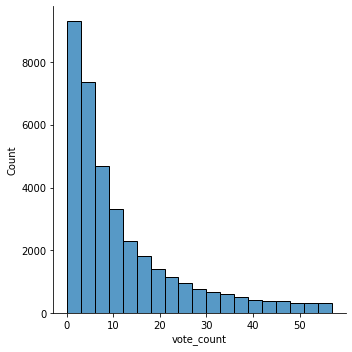

In [329]:
# Step 2: drop movies that not many people have watched as it can create bias 
sns.displot(movies_df, x = "vote_count", bins = [i for i in range(0, 60, 3)])
vote_threshold = 3
movies_df = movies_df[movies_df['vote_count'] >= vote_threshold]

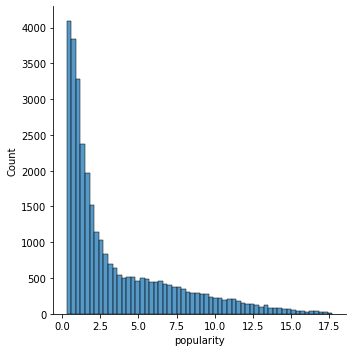

In [330]:
# Step 3: drop non-popular movies as they will likely not be recommended
movies_df['popularity'] = movies_df['popularity'].apply(lambda x : float(x))
sns.displot(movies_df, x = "popularity", bins = [i*0.3 for i in range(1, 60)])
popular_threshold = 0.6
movies_df = movies_df[movies_df['popularity'] >= popular_threshold]

In [331]:
# Step 4 : convert str --> [array of words]
movies_df['genres'] = movies_df['genres'].apply(lambda x : str_parser(x))
movies_df.dropna(inplace=True)

movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x : str_parser(x))
movies_df.dropna(inplace=True)

Now that movies and keywords have been cleaned, let's join the two together. 

In [332]:
# join movies_df and keywords_df 
movies_df['genres'] = movies_df['genres'].apply(lambda x : str(x))
movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x : str(x))
keywords_df['keywords'] = keywords_df['keywords'].apply(lambda x : str(x)) 

query = '''
select m.id, title, 
production_companies, genres,
keywords, popularity, 
vote_average, vote_count
from movies_df as m
join keywords_df as k
on m.id = k.id
'''

movies_df = ps.sqldf(query, locals())

In [333]:
# cleansing ratings 

# Step 1 : ratings_df is a very large dataset sorted by userId 
# we do not need to use all of the users as part of training 
ratings_df = ratings_df[ratings_df['userId'] <= 10000]

# Step 2 : drop unnecessary columns 
ratings_df.drop(columns = ['timestamp'], inplace=True) 

In [334]:
# Step 3 : get rid of ratings for movies not in movies_df 
query = '''
select * 
from ratings_df 
where movieId in (
  select id 
  from movies_df
)
'''

ratings_df = ps.sqldf(query, locals())

In [335]:
# Step 4 : get rid of movies not rated in ratings_df 
query = '''
select * 
from movies_df 
where id in (
  select movieId 
  from ratings_df
)
'''

movies_df = ps.sqldf(query, locals())

In [336]:
# Finally convert columns to how we want them 
movies_df['genres'] = movies_df['genres'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
movies_df['production_companies'] = movies_df['production_companies'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
keywords_df['keywords'] = keywords_df['keywords'].apply(lambda x : eval("[" + x[1:-1] + "]"))

In [337]:
# Make sure we have enough unique users before continuing
query = '''
select userId, count(movieId)
from ratings_df
group by userId
'''

ps.sqldf(query, locals()).shape

(9779, 2)

## Data Exploration & Visualization

Is it safe to assume that non-popular production companies didn't make any popular movies? Let's find out. 

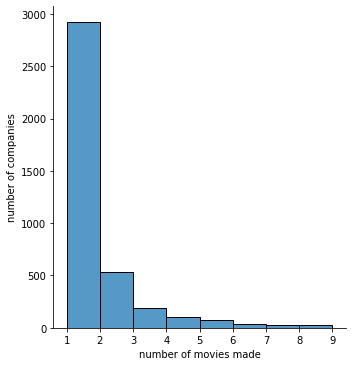

In [338]:
companies = [company for companies in movies_df['production_companies'] for company in companies]
freq = collections.Counter(companies)

ax = sns.displot(freq, x = freq.values(), bins = [i for i in range(1, 10)])
ax.set(xlabel='number of movies made', ylabel='number of companies')

From the plot above, we can tell there are a lot of companies that have made just 1 movie.

Now let's check if any of these companies have produced a movie that turned out to be a success.

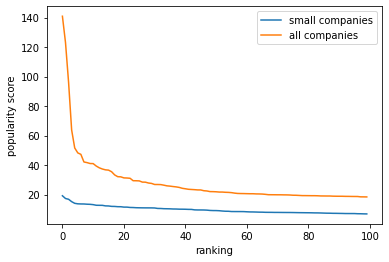

In [339]:
large_companies = {k for k,v in freq.items() if v > 1}
number_of_rows = movies_df.count()[0]

popularity_by_small_companies = []
popularity_by_all_companies = []

for i in range(number_of_rows):
  small = True 
  for company in movies_df['production_companies'].iloc[i]:
    if company in large_companies:
      small = False 
      break 
  if small:
    popularity_by_small_companies.append(movies_df['popularity'].iloc[i])
   
plt.plot(sorted(popularity_by_small_companies, reverse=True)[:100], label='small companies')  
plt.plot(sorted(movies_df['popularity'], reverse=True)[:100], label='all companies') 
plt.xlabel('ranking'); plt.ylabel('popularity score')
plt.legend()

It appears small companies never made any movies that are within the top 100 popular movies.

However, looking at our graph, it appears that starting from the 40th most popular movie, there really isn't a large discrepency that proves small companies make only non-popular movies. 

Therefore, we can disregard production companies as a factor for recommending movies. 


In [340]:
movies_df.drop(columns = ['production_companies'], inplace=True)

So now let's look at the genre column.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'count')

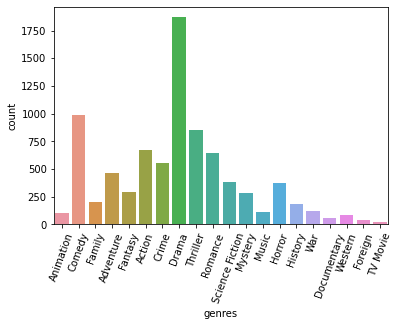

In [341]:
all_genres = {}

for i in range(number_of_rows):
  for genre in movies_df['genres'].iloc[i]:
    all_genres[genre] = all_genres.get(genre, 0) + 1

sns.barplot(list(all_genres.keys()), list(all_genres.values()))
plt.xticks(rotation=70)
plt.xlabel('genres')
plt.ylabel('count')  

It appears that there are a total of 20 genres.

The most popular genre is 'Drama', and the least popular is 'Foreign'. 

So let's discover how each user in ratings_df rates each category based on the movies they rated. 

In [342]:
# Step 1 : create a copy of ratings_df and merge genres from movies_df
genres_df = ratings_df.copy(deep=True)
movies_df['genres'] = movies_df['genres'].apply(lambda x : str(x))

query = '''
select *
from genres_df as g
join movies_df as m
on g.movieId = m.id
'''

genres_df = ps.sqldf(query, locals())
genres_df.drop(columns=['id', 'keywords', 'popularity',\
                        'vote_average', 'vote_count',
                        'movieId', 'title'], inplace=True)
genres_df.sort_values(by=['userId'], inplace=True)

movies_df['genres'] = movies_df['genres'].apply(lambda x : eval("[" + x[1:-1] + "]")) 
genres_df['genres'] = genres_df['genres'].apply(lambda x : eval("[" + x[1:-1] + "]")) 

In [343]:
# Step 2 : append all the genres as columns 
number_of_rows = genres_df.count()[0]

for genre in all_genres.keys():
  genres_df[genre] = [0 for _ in range(number_of_rows)]

In [344]:
# Step 3 : assign scores to the columns 
for i in range(number_of_rows):
  for genre in genres_df['genres'].iloc[i]:  
    genres_df[genre].iloc[i] += 1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [345]:
# Step 4 : group by to average
genres_df.drop(columns=['rating','genres'], inplace=True)

query = '''
select userId, avg(Animation) as avg_animation, avg(Comedy) as avg_comedy,
avg(Family) as avg_family, avg(Action) as avg_action, avg(Crime) as avg_crime,
avg(Drama) as avg_drama, avg(Thriller) as avg_thriller, avg(Romance) as avg_romance,
avg("Science Fiction") as avg_science_fiction, avg(Mystery) as avg_mystery, 
avg(Music) as avg_music, avg(Horror) as avg_horror, avg(War) as avg_war, 
avg(Documentary) as avg_documentary, avg(Western) as avg_western, 
avg("Foreign") as avg_foreign, avg("TV Movie") as avg_tv_movie
from genres_df
group by userId
'''

genres_df = ps.sqldf(query, locals())

In [151]:
# Leaving a note for Kelly and Henry ! 

# We eventually want to have a dataset with a really long column that looks like 
# userID | movie1 movie2 movie3 .. | genre1 genre2 ... | keyword1 keyword2 .. | ....
# (or maybe we don't if we can come up with other ideas!)

# You can imagine that this will be a LOT of columns, so we do need to minimize that 
# We can think of some criteria to shorten the number of movies together at a later stage 
# What we can do as of now is find frequent keywords (and maybe create a word cloud)
# and get rid of infrequent keywords 

# Maybe at a later stage, we can think of some way to do sentiment analysis to separate the 
# keywords into discrete categories (category 1, category 2 etc.) to shorten columns further  

In [ ]:
# We currently have these 3 data frames
movies_df
ratings_df
genres_df